In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
# # !pip install comet_ml
# !pip install -U textblob
# !pip install nltk




In [100]:
from comet_ml import Experiment
# Создайте эксперимент с помощью вашего API ключа
experiment = Experiment(
    api_key="6Ga3e8coVWoOIpAreIY8DKEgJ",
    project_name="hotels",
    workspace="dekoz",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/dekoz/hotels/5e60cef54eb1415ba6cf90e6acc87788



In [101]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
random_state = 42
RANDOM_SEED = random_state

In [102]:

    # sentences = [
    #     ':)',
    #     ':(',
    #     'She is so :(',
    #     'I love the way cricket is played by the champions',
    #     'She neither likes coffee nor tea',
    # ]
    # senti = SentimentIntensityAnalyzer()
    # print(' -- built-in intensity analyser --')
    # for sentence in sentences:
    #     print('[{}]'.format(sentence), end=' --> ')
    #     kvp = senti.polarity_scores(sentence)
    #     for k in kvp:
    #         print('{} = {}, '.format(k, kvp[k]), end='')
    #     print() 

In [103]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [104]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

COMET ERROR: Failed to log git patch


In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [106]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [108]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [109]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [110]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [111]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [113]:
# Spleeting review_date column to year, month, day 
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=True)
data['year'] = data['review_date'].apply(lambda x: x.year)
data['month'] = data['review_date'].apply(lambda x: x.month)
data['day'] = data['review_date'].apply(lambda x: x.day)
data.drop('review_date', axis=1, inplace=True)


In [114]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)
data.drop('lat', axis=1, inplace=True)
data.drop('lng', axis=1, inplace=True)

data.drop('additional_number_of_scoring', axis=1, inplace=True)

In [115]:
data[data['sample']==1].head(5)

,hotel_address,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,year,month,day
128935,Stratton Street Mayfair Westminster Borough Lo...,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,1,10.0,2016,2,19
128936,130 134 Southampton Row Camden London WC1B 5AF...,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,1,6.3,2017,12,1
128937,151 bis Rue de Rennes 6th arr 75006 Paris France,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,1,7.5,2016,10,18
128938,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,1,10.0,2015,9,22
128939,Molenwerf 1 1014 AG Amsterdam Netherlands,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,1,9.6,2016,5,3


In [116]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import nltk

senty = SentimentIntensityAnalyzer()

data['senty_neg'] = data['negative_review'].apply(lambda x: - (senty.polarity_scores(x))["compound"])
data['senty_pos'] = data['positive_review'].apply(lambda x: (senty.polarity_scores(x))["compound"])



In [117]:
data[data['sample']==1].head(5)

,hotel_address,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,year,month,day,senty_neg,senty_pos
128935,Stratton Street Mayfair Westminster Borough Lo...,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,1,10.0,2016,2,19,-0.0000,0.5859
128936,130 134 Southampton Row Camden London WC1B 5AF...,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,1,6.3,2017,12,1,0.4767,0.0000
128937,151 bis Rue de Rennes 6th arr 75006 Paris France,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,1,7.5,2016,10,18,0.2960,0.3400
128938,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,1,10.0,2015,9,22,0.7096,0.9169
128939,Molenwerf 1 1014 AG Amsterdam Netherlands,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,1,9.6,2016,5,3,0.2500,0.8503


In [118]:
data.nunique(dropna=False)

hotel_address                                   1493
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
sample                                             2
reviewer_score                                    38
year                                               3
month                                             12
day                                               31
senty_neg                                      15978
senty_pos                                     

<AxesSubplot:>

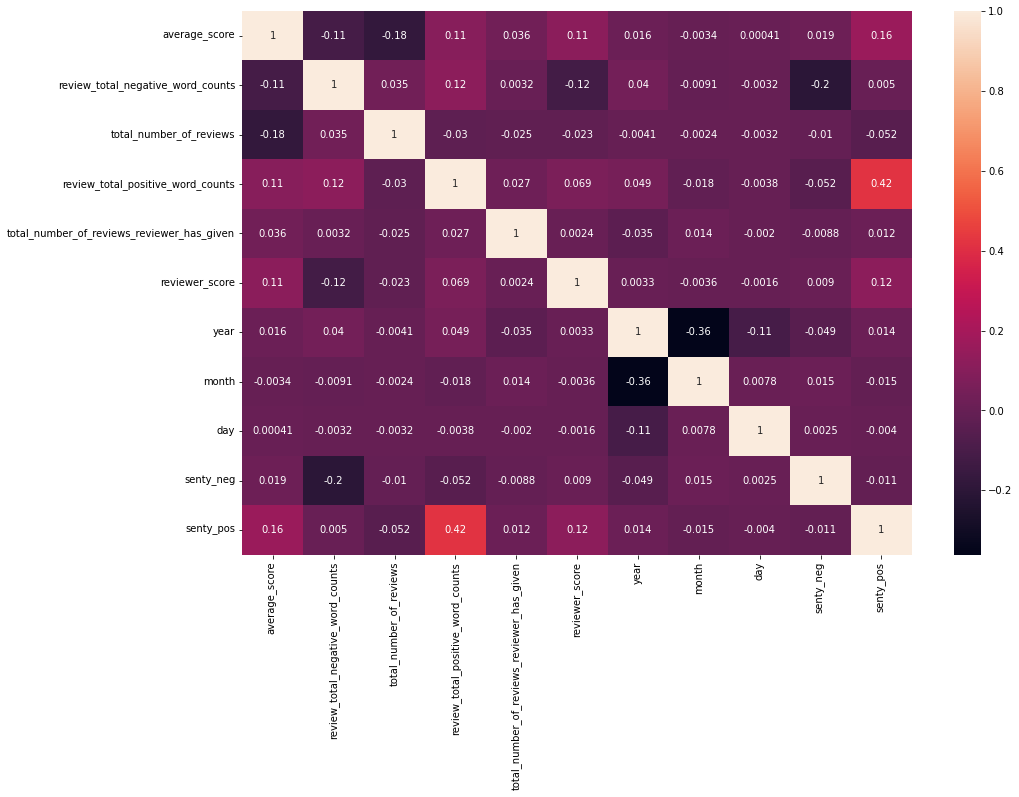

In [119]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [120]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   year                                        515738 non-null  int64  
 8   month                                       515738 non-null  int64  
 9   day                                         515738 non-null  int64  
 

In [122]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [123]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [124]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 11), (386803, 11), (386803, 10), (309442, 10), (77361, 10))

In [125]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [126]:
n_estimators = 100

In [127]:
params={"random_state":random_state, 
        "n_estimators":n_estimators
 
}

In [128]:
experiment.log_parameters(params)

In [129]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=n_estimators, verbose=1, n_jobs=-1, random_state=random_state)

In [130]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [131]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
import numpy as np
 
# Функция для вычисления MAPE
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
mape = mape_func(y_test, y_pred)
#mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)
metric = {'MAPE': mape}
# MAPE: 13.777297973454605 del lat lng
# MAPE: 12.665555224247374 ntlk 
# MAPE: 12.665375224247374 del additional_number_of_scoring

MAPE: 12.665375224247374


{'web': 'https://www.comet.ml/api/image/download?imageId=2592a5939ed944afaf23ca0deb78b526&experimentKey=5e60cef54eb1415ba6cf90e6acc87788',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2592a5939ed944afaf23ca0deb78b526&experimentKey=5e60cef54eb1415ba6cf90e6acc87788',
 'imageId': '2592a5939ed944afaf23ca0deb78b526'}

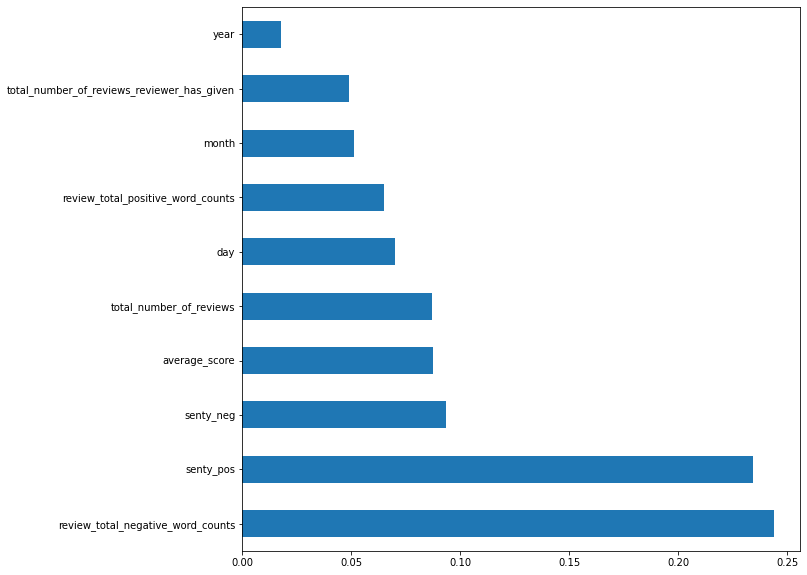

In [132]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
experiment.log_figure()

In [133]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,year,month,day,senty_neg,senty_pos
19824,9.0,7,1974,121,1,0.0,2017,5,14,-0.0000,0.9930
83796,8.4,0,6117,14,1,0.0,2017,6,26,0.7096,0.6249
53504,8.5,0,1158,20,1,0.0,2016,7,2,0.7096,0.7764
34191,8.4,3,845,27,1,0.0,2016,7,6,-0.0000,0.9732
90906,9.2,8,4017,71,6,0.0,2016,12,3,-0.0000,0.8173
72466,8.1,12,7105,11,1,0.0,2016,3,5,-0.4404,0.8360
36140,9.2,8,1017,56,1,0.0,2017,1,30,0.3400,0.9792
86872,8.5,0,4032,13,3,0.0,2015,6,9,0.7096,0.4754
41901,8.0,37,1894,9,13,0.0,2016,5,15,0.7430,0.7841
128642,8.9,4,7108,3,3,0.0,2015,11,22,-0.0000,0.0000


In [134]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [135]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [136]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


In [137]:
predict_submission

array([8.77 , 7.532, 8.649, ..., 8.519, 9.534, 7.191])

In [138]:
list(sample_submission)

['reviewer_score', 'id']

In [139]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_ntlk.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.770,488440
1,7.532,274649
2,8.649,374688
3,9.749,404352
4,9.860,451596
5,9.065,302161
6,8.294,317079
7,7.476,13963
8,8.719,159785
9,7.817,195089


In [140]:
experiment.log_metrics(metric)

In [141]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/dekoz/hotels/5e60cef54eb1415ba6cf90e6acc87788
COMET INFO:   Metrics:
COMET INFO:     MAPE : 12.665375224247374
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     criterion                : squared_error
COMET INFO:     max_depth                : 1
COMET INFO:     max_features             : 1.0
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_weight_fraction_leaf : 0.0
COMET INFO:     n_estimators             : 100
COMET INFO:     n_jobs                   : -1
COMET INF